## Erste Optimierung -> Kosteneinsparung mit vs. ohne PV

In [1]:

# For pvlib
import pvlib
import pandas as pd # 'as pd' to change alias from pandas to pd
import matplotlib.pyplot as plt
import pgeocode

# For demandlib
import datetime
from datetime import time as settime
import numpy as np
from demandlib import bdew
import demandlib.bdew as bdew
import demandlib.particular_profiles as profiles
from workalendar.europe import Germany

# Input
plz = 40599
anlage_groesse = 10 
strom_bedarf = 4000
waerme_bedarf = 20000


# Standort
nomi = pgeocode.Nominatim('de') 
a = nomi.query_postal_code(plz)
latitude = a['latitude']
longitude = a['longitude']

# Get hourly solar irradiation and modeled PV power output from PVGIS
data, meta, inputs = pvlib.iotools.get_pvgis_hourly(latitude, longitude, start=2016, end=2016, surface_tilt=35,
                                                    pvcalculation=True, peakpower=anlage_groesse, mountingplace='building', loss = 0)  


In [2]:
# Change Index to match demandlib index
year = 2016
data.set_index(pd.date_range(datetime.datetime(year, 1, 1, 0), periods= len(data), freq="h"), inplace=True)

In [3]:
# PV Profil
data['P']

2016-01-01 00:00:00    0.0
2016-01-01 01:00:00    0.0
2016-01-01 02:00:00    0.0
2016-01-01 03:00:00    0.0
2016-01-01 04:00:00    0.0
                      ... 
2016-12-31 19:00:00    0.0
2016-12-31 20:00:00    0.0
2016-12-31 21:00:00    0.0
2016-12-31 22:00:00    0.0
2016-12-31 23:00:00    0.0
Freq: h, Name: P, Length: 8784, dtype: float64

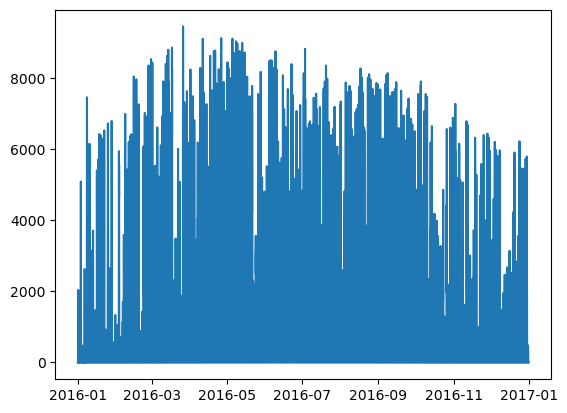

In [4]:
# Plot PV power
plt.plot(data['P'])

In [5]:
## Stromprofil - demandlib ##
# Get holidays
cal = Germany()
holidays = dict(cal.holidays(year))

In [6]:
ann_el_demand_per_sector = {
    "h0_dyn": strom_bedarf,
}

# read standard load profiles
e_slp = bdew.ElecSlp(year, holidays=holidays)

# multiply given annual demand with timeseries
elec_demand = e_slp.get_profile(ann_el_demand_per_sector)
elec_demand # Takt: 15 Minuten


c:\Users\DianaEspinosaLozano\anaconda3\envs\thesis\Lib\site-packages\demandlib\bdew\elec_slp.py:155: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[7 7 7 ... 6 6 6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  new_df.update(merged_df)
c:\Users\DianaEspinosaLozano\anaconda3\envs\thesis\Lib\site-packages\demandlib\bdew\elec_slp.py:155: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  0 ... 23 23 23]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  new_df.update(merged_df)
c:\Users\DianaEspinosaLozano\anaconda3\envs\thesis\Lib\site-packages\demandlib\bdew\elec_slp.py:155: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 15 30 ... 15 30 45]' has dtype incompatible with int32, please expl

,h0_dyn
2016-01-01 00:00:00,0.432893
2016-01-01 00:15:00,0.401611
2016-01-01 00:30:00,0.371318
2016-01-01 00:45:00,0.342015
2016-01-01 01:00:00,0.314097
...,...
2016-12-31 22:45:00,0.597245
2016-12-31 23:00:00,0.572801
2016-12-31 23:15:00,0.542697
2016-12-31 23:30:00,0.509559


In [7]:
# pro 15 Minuten zu pro Stunde 
elec_demand_hourly = elec_demand.resample("h").mean() 
elec_demand_hourly

,h0_dyn
2016-01-01 00:00:00,0.386959
2016-01-01 01:00:00,0.278753
2016-01-01 02:00:00,0.223167
2016-01-01 03:00:00,0.203622
2016-01-01 04:00:00,0.191801
...,...
2016-12-31 19:00:00,1.061405
2016-12-31 20:00:00,0.868713
2016-12-31 21:00:00,0.677457
2016-12-31 22:00:00,0.618953


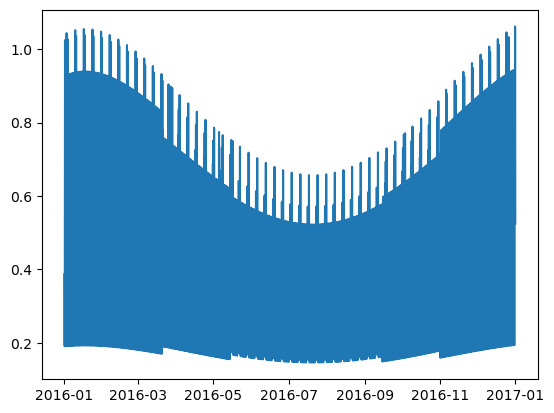

In [8]:
plt.plot(elec_demand_hourly['h0_dyn'])

In [9]:
elec_demand_hourly.info() # ist DataFrame

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2016-01-01 00:00:00 to 2016-12-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   h0_dyn  8784 non-null   float64
dtypes: float64(1)
memory usage: 137.2 KB


In [10]:
data['P'].info() # ist Series

<class 'pandas.core.series.Series'>
DatetimeIndex: 8784 entries, 2016-01-01 00:00:00 to 2016-12-31 23:00:00
Freq: h
Series name: P
Non-Null Count  Dtype  
--------------  -----  
8784 non-null   float64
dtypes: float64(1)
memory usage: 137.2 KB


In [11]:
# PV Profil in Strom Profil DataFrame hinzufügen (in kWh)
# Neue Spalte in elec_demand_hourly 
elec_demand_hourly['pv'] = data['P'].div(1000)

In [12]:
elec_demand_hourly

,h0_dyn,pv
2016-01-01 00:00:00,0.386959,0.0
2016-01-01 01:00:00,0.278753,0.0
2016-01-01 02:00:00,0.223167,0.0
2016-01-01 03:00:00,0.203622,0.0
2016-01-01 04:00:00,0.191801,0.0
...,...,...
2016-12-31 19:00:00,1.061405,0.0
2016-12-31 20:00:00,0.868713,0.0
2016-12-31 21:00:00,0.677457,0.0
2016-12-31 22:00:00,0.618953,0.0


In [13]:
# Substract
elec_demand_hourly['sub'] = elec_demand_hourly['pv'] - elec_demand_hourly['h0_dyn']
elec_demand_hourly

,h0_dyn,pv,sub
2016-01-01 00:00:00,0.386959,0.0,-0.386959
2016-01-01 01:00:00,0.278753,0.0,-0.278753
2016-01-01 02:00:00,0.223167,0.0,-0.223167
2016-01-01 03:00:00,0.203622,0.0,-0.203622
2016-01-01 04:00:00,0.191801,0.0,-0.191801
...,...,...,...
2016-12-31 19:00:00,1.061405,0.0,-1.061405
2016-12-31 20:00:00,0.868713,0.0,-0.868713
2016-12-31 21:00:00,0.677457,0.0,-0.677457
2016-12-31 22:00:00,0.618953,0.0,-0.618953


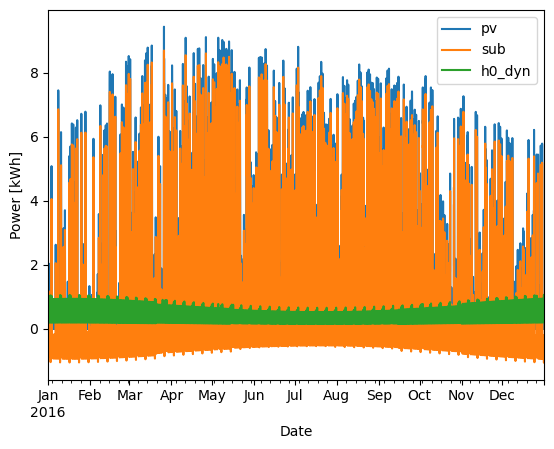

In [14]:
elec_demand_hourly = elec_demand_hourly[['pv', 'sub', 'h0_dyn']]
ax = elec_demand_hourly.plot()
ax.set_xlabel("Date")
ax.set_ylabel("Power [kWh]")
plt.show()

In [15]:
# Netzbezug
pd.options.mode.copy_on_write = True # compute without SettingWithCopyingWarning: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

zero = 0 
elec_demand_hourly['Netzbezug'] = elec_demand_hourly['sub'].abs().where(elec_demand_hourly['sub'] < zero, other = 0)
netzbezug_j = elec_demand_hourly['Netzbezug'].sum()
netzbezug_j

2155.8378036441895

In [16]:
# PV Eigenverbrauch
elec_demand_hourly['Eigenverbrauch'] = elec_demand_hourly['h0_dyn'].where(elec_demand_hourly['sub'] > zero, other = 0)
eigenverbrauch_j = elec_demand_hourly['Eigenverbrauch'].sum()
eigenverbrauch_j

1640.3702214157138

In [17]:
# PV Einspeisung
elec_demand_hourly['Einspeisung'] = elec_demand_hourly['sub'].where(elec_demand_hourly['sub'] > zero, other = 0)
einspeisung_j = elec_demand_hourly['Einspeisung'].sum()
einspeisung_j

9419.135578584286

In [18]:
elec_demand_hourly

,pv,sub,h0_dyn,Netzbezug,Eigenverbrauch,Einspeisung
2016-01-01 00:00:00,0.0,-0.386959,0.386959,0.386959,0.0,0.0
2016-01-01 01:00:00,0.0,-0.278753,0.278753,0.278753,0.0,0.0
2016-01-01 02:00:00,0.0,-0.223167,0.223167,0.223167,0.0,0.0
2016-01-01 03:00:00,0.0,-0.203622,0.203622,0.203622,0.0,0.0
2016-01-01 04:00:00,0.0,-0.191801,0.191801,0.191801,0.0,0.0
...,...,...,...,...,...,...
2016-12-31 19:00:00,0.0,-1.061405,1.061405,1.061405,0.0,0.0
2016-12-31 20:00:00,0.0,-0.868713,0.868713,0.868713,0.0,0.0
2016-12-31 21:00:00,0.0,-0.677457,0.677457,0.677457,0.0,0.0
2016-12-31 22:00:00,0.0,-0.618953,0.618953,0.618953,0.0,0.0


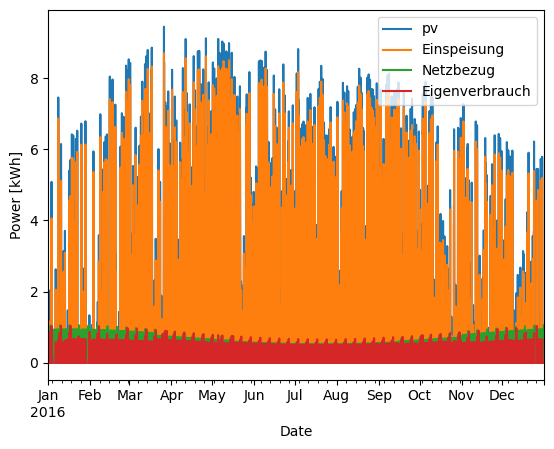

In [19]:
elec_demand_plot = elec_demand_hourly[['pv','Einspeisung', 'Netzbezug', 'Eigenverbrauch']]
ax = elec_demand_plot.plot()
ax.set_xlabel("Date")
ax.set_ylabel("Power [kWh]")
plt.show()

In [20]:
# Kosten - Netzbezug
# Strompreis 2024: 41,35 Cent/kWh (https://www.bdew.de/service/daten-und-grafiken/bdew-strompreisanalyse/)
strompreis = 0.4135
Kosten_Netzbezug = netzbezug_j*(strompreis)
round(Kosten_Netzbezug, 2)

891.44

In [21]:
# Einspeisung
# Einspeisevergutung 2024: Feb-Aug: 8,1 ct, Aug-Feb25: 8 ct (https://photovoltaik.org/kosten/einspeiseverguetung)

einspeisevergutung = 0.08
Gewinn_Einspeisung = einspeisung_j*einspeisevergutung
Gewinn_Einspeisung

753.5308462867429

In [22]:
# Kosten ohne PV

Rechnung_ohne_pv = elec_demand_hourly['h0_dyn'].sum()*strompreis
Rechnung_ohne_pv

1655.34930221227

In [23]:
# Kosten mit PV

Rechnung_mit_pv = Kosten_Netzbezug - Gewinn_Einspeisung 
Rechnung_mit_pv

137.90808552012948

In [24]:
# Einsparung 

Einsparung = Rechnung_ohne_pv - Rechnung_mit_pv
Einsparung

1517.4412166921406

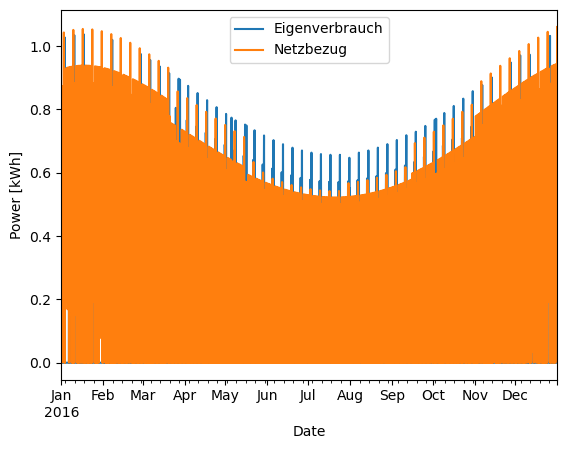

In [25]:
# Plot Eigenverbrauch vs. Netzbezug

vergleich_plot = elec_demand_hourly[['Eigenverbrauch', 'Netzbezug']]
vx = vergleich_plot.plot()
vx.set_xlabel("Date")
vx.set_ylabel("Power [kWh]")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

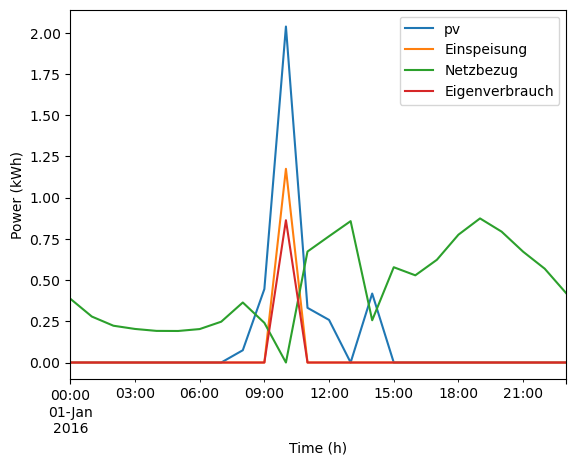

In [26]:
# 1 Tag: 1.1.2016
tag = elec_demand_hourly.loc['2016-01-01 00:00:00':'2016-01-01 23:00:00', ['pv','Einspeisung', 'Netzbezug', 'Eigenverbrauch']]
tag_plot = tag.plot()
tag_plot.set_xlabel('Time (h)')
tag_plot.set_ylabel('Power (kWh)')
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

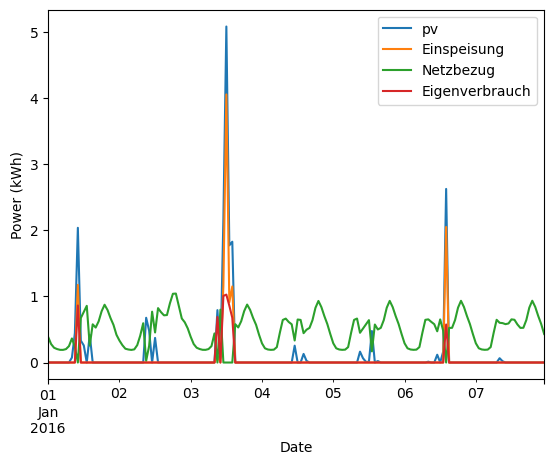

In [27]:
# 1 Woche: 1.-7.1.16
woche = elec_demand_hourly.loc['2016-01-01 00:00:00':'2016-01-07 23:00:00', ['pv','Einspeisung', 'Netzbezug', 'Eigenverbrauch']]
woche_plot = woche.plot()
woche_plot.set_xlabel('Date')
woche_plot.set_ylabel('Power (kWh)')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

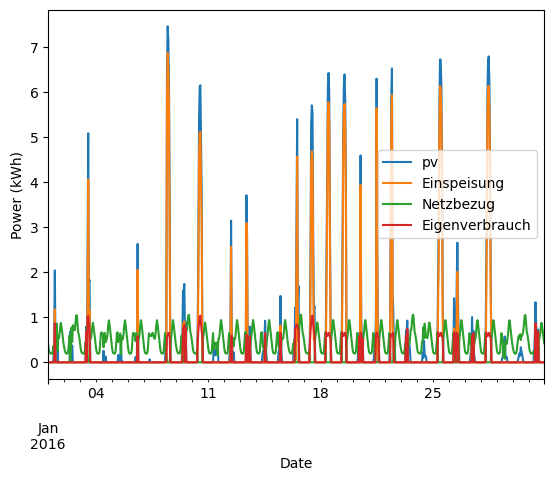

In [28]:
# 1 Monat: Januar 16
monat = elec_demand_hourly.loc['2016-01-01 00:00:00':'2016-01-31 23:00:00', ['pv','Einspeisung', 'Netzbezug', 'Eigenverbrauch']]
monat_plot = monat.plot()
monat_plot.set_xlabel('Date')
monat_plot.set_ylabel('Power (kWh)')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

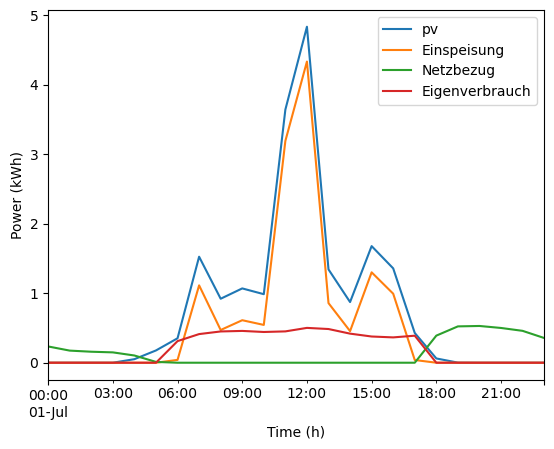

In [29]:
# 1 Tag: 1.7.2016
tag = elec_demand_hourly.loc['2016-07-01 00:00:00':'2016-07-01 23:00:00', ['pv','Einspeisung', 'Netzbezug', 'Eigenverbrauch']]
tag_plot = tag.plot()
tag_plot.set_xlabel('Time (h)')
tag_plot.set_ylabel('Power (kWh)')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

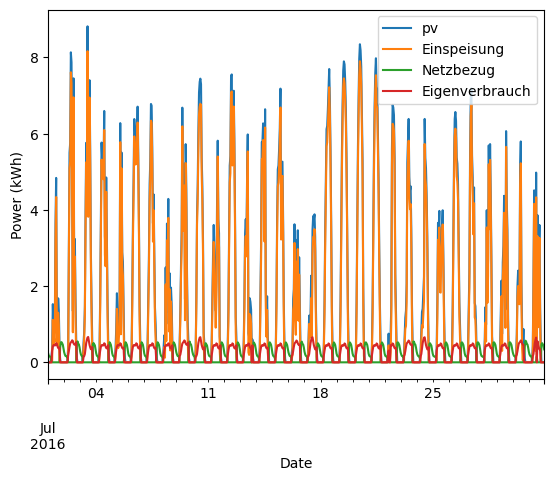

In [30]:
# 1 Monat: July 16
monat = elec_demand_hourly.loc['2016-07-01 00:00:00':'2016-07-31 23:00:00', ['pv','Einspeisung', 'Netzbezug', 'Eigenverbrauch']]
monat_plot = monat.plot()
monat_plot.set_xlabel('Date')
monat_plot.set_ylabel('Power (kWh)')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

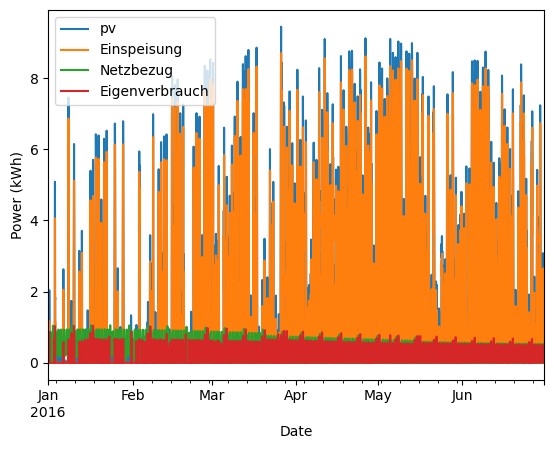

In [31]:
# 1. Jahreshälfte: Januar bis Juli 16
monat = elec_demand_hourly.loc['2016-01-01 00:00:00':'2016-06-30 23:00:00', ['pv','Einspeisung', 'Netzbezug', 'Eigenverbrauch']]
monat_plot = monat.plot()
monat_plot.set_xlabel('Date')
monat_plot.set_ylabel('Power (kWh)')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

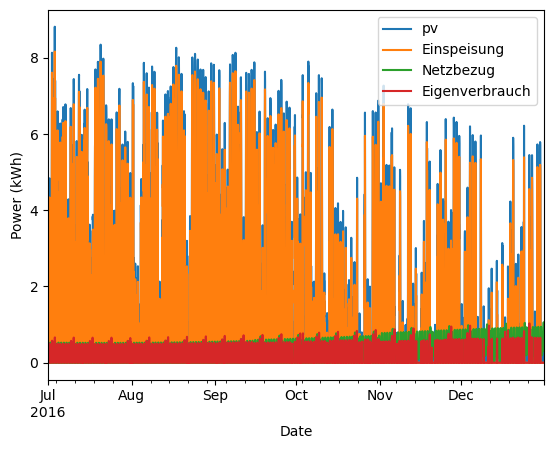

In [32]:
# 2. Jahreshälfte: Juli bis Januar 16
monat = elec_demand_hourly.loc['2016-07-01 00:00:00':'2016-12-31 23:00:00', ['pv','Einspeisung', 'Netzbezug', 'Eigenverbrauch']]
monat_plot = monat.plot()
monat_plot.set_xlabel('Date')
monat_plot.set_ylabel('Power (kWh)')
plt.show

In [33]:
# elec_demand_hourly.to_csv('elec_demand_hourly_240723.csv')


<function matplotlib.pyplot.show(close=None, block=None)>

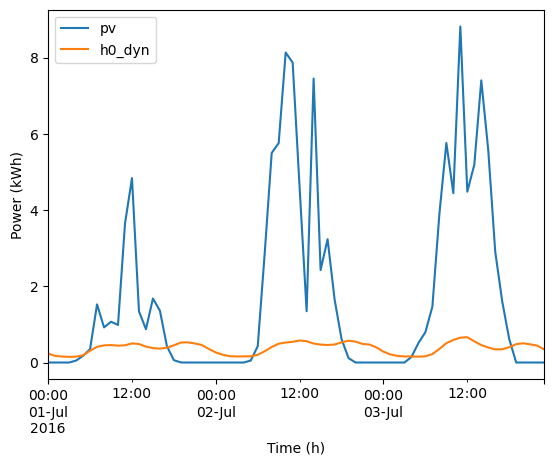

In [36]:
# 1 Tag: 1.1.2016
tag = elec_demand_hourly.loc['2016-07-01 00:00:00':'2016-07-03 23:00:00', ['pv','h0_dyn']]
tag_plot = tag.plot()
tag_plot.set_xlabel('Time (h)')
tag_plot.set_ylabel('Power (kWh)')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

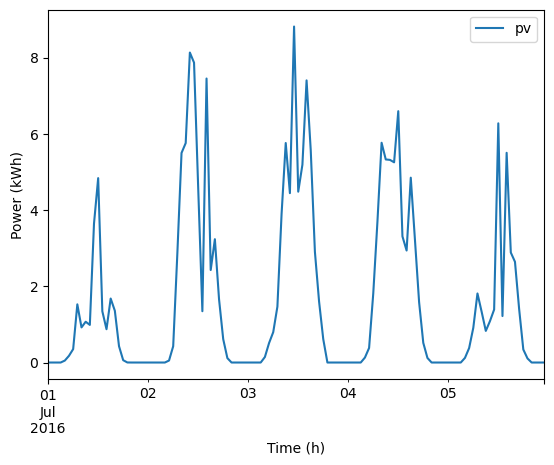

In [37]:
# 1 Tag: 1.1.2016
tag = elec_demand_hourly.loc['2016-07-01 00:00:00':'2016-07-05 23:00:00', ['pv']]
tag_plot = tag.plot()
tag_plot.set_xlabel('Time (h)')
tag_plot.set_ylabel('Power (kWh)')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

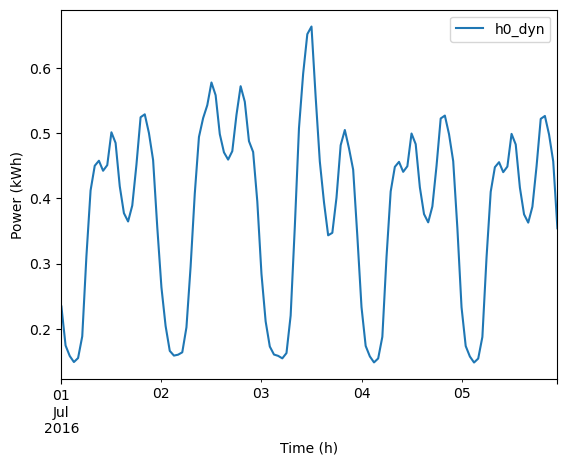

In [40]:
# 1 Tag: 1.1.2016
tag = elec_demand_hourly.loc['2016-07-01 00:00:00':'2016-07-05 23:00:00', ['h0_dyn']]
tag_plot = tag.plot()
tag_plot.set_xlabel('Time (h)')
tag_plot.set_ylabel('Power (kWh)')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

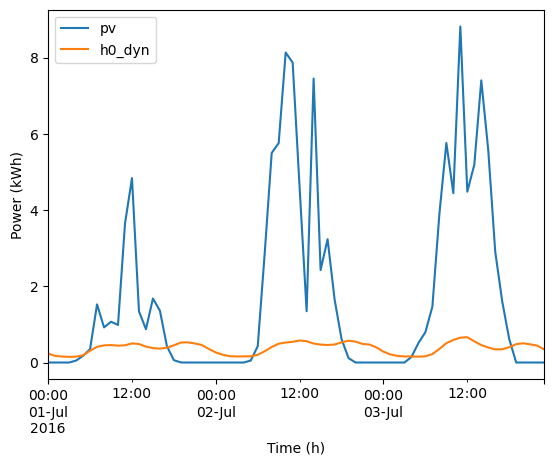

In [43]:
# 1 Tag: 1.1.2016
tag = elec_demand_hourly.loc['2016-07-01 00:00:00':'2016-07-03 23:00:00', ['pv','h0_dyn']]
tag_plot = tag.plot()
tag_plot.set_xlabel('Time (h)')
tag_plot.set_ylabel('Power (kWh)')
plt.show